In [1]:
import timesfm
# For Torch
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=128,
          horizon_len=128,
          num_layers=50,
          use_positional_embedding=False,
          context_len=1024,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.


/home/userroot/miniconda3/envs/ts/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded PyTorch TimesFM, likely because python version is 3.11.11 (main, Dec 11 2024, 16:28:39) [GCC 11.2.0].


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 19257.59it/s]


In [22]:
import numpy as np
forecast_input = [
    np.sin(np.linspace(0, 20, 100)),
    np.sin(np.linspace(0, 20, 200)),
    np.sin(np.linspace(0, 20, 400)),
]
frequency_input = [0, 1, 2]

point_forecast, experimental_quantile_forecast = tfm.forecast(
    forecast_input,
    freq=frequency_input,
)

In [24]:
point_forecast.shape

(3, 128)

In [12]:
#生成随机三维tensor
import torch


t_in = torch.randn(256, 4, 128)

In [13]:
t_in = t_in.reshape(-1, 128)

In [15]:
out = tfm.forecast(t_in)

In [21]:
out[0].shape

(1024, 128)

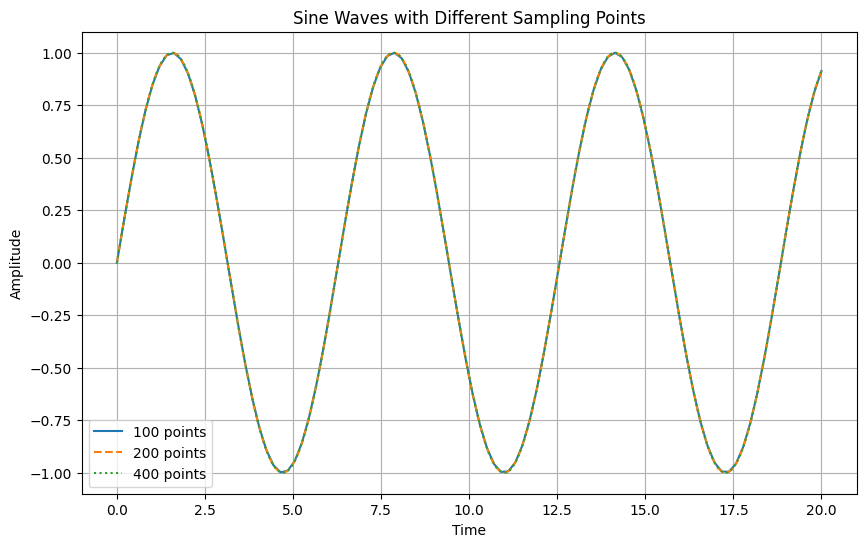

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 定义数据
forecast_input = [
    np.sin(np.linspace(0, 20, 100)),  # 100 个点
    np.sin(np.linspace(0, 20, 200)),  # 200 个点
    np.sin(np.linspace(0, 20, 400)),  # 400 个点
]

# 创建时间轴（x 轴），长度与每个序列对应
x1 = np.linspace(0, 20, 100)
x2 = np.linspace(0, 20, 200)
x3 = np.linspace(0, 20, 400)

# 绘制图像
plt.figure(figsize=(10, 6))  # 设置图像大小
plt.plot(x1, forecast_input[0], label='100 points', linestyle='-', linewidth=1.5)
plt.plot(x2, forecast_input[1], label='200 points', linestyle='--', linewidth=1.5)
plt.plot(x3, forecast_input[2], label='400 points', linestyle=':', linewidth=1.5)

# 添加标题和标签
plt.title('Sine Waves with Different Sampling Points')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()  # 显示图例
plt.grid(True)  # 添加网格线

# 显示图像
plt.show()

In [5]:
point_forecast[0,:]

array([ 9.83747244e-01,  1.01065361e+00,  1.00325358e+00,  9.46732640e-01,
        8.51727128e-01,  7.23342836e-01,  5.61207771e-01,  3.80571663e-01,
        1.79073259e-01, -2.67257988e-02, -2.32114047e-01, -4.27830368e-01,
       -5.99026322e-01, -7.64772177e-01, -8.78619432e-01, -9.67811108e-01,
       -1.01031446e+00, -1.01604700e+00, -9.84019876e-01, -9.12956357e-01,
       -8.01771522e-01, -6.50981665e-01, -4.71728057e-01, -2.84182280e-01,
       -7.70836174e-02,  1.27240524e-01,  3.29177767e-01,  5.12138844e-01,
        6.82633519e-01,  8.17140102e-01,  9.16526914e-01,  9.84637737e-01,
        1.01296473e+00,  1.00419533e+00,  9.52391267e-01,  8.54743481e-01,
        7.38911271e-01,  5.88088036e-01,  4.05613095e-01,  2.08451092e-01,
       -5.27352095e-04, -2.10887402e-01, -4.13263947e-01, -6.05157018e-01,
       -7.68680930e-01, -8.80226731e-01, -9.74400759e-01, -1.02037847e+00,
       -1.02086878e+00, -9.88066435e-01, -9.13966298e-01, -8.08943152e-01,
       -6.66440606e-01, -

In [6]:
experimental_quantile_forecast[0,:,5]

array([ 9.83747244e-01,  1.01065361e+00,  1.00325358e+00,  9.46732640e-01,
        8.51727128e-01,  7.23342836e-01,  5.61207771e-01,  3.80571663e-01,
        1.79073259e-01, -2.67257988e-02, -2.32114047e-01, -4.27830368e-01,
       -5.99026322e-01, -7.64772177e-01, -8.78619432e-01, -9.67811108e-01,
       -1.01031446e+00, -1.01604700e+00, -9.84019876e-01, -9.12956357e-01,
       -8.01771522e-01, -6.50981665e-01, -4.71728057e-01, -2.84182280e-01,
       -7.70836174e-02,  1.27240524e-01,  3.29177767e-01,  5.12138844e-01,
        6.82633519e-01,  8.17140102e-01,  9.16526914e-01,  9.84637737e-01,
        1.01296473e+00,  1.00419533e+00,  9.52391267e-01,  8.54743481e-01,
        7.38911271e-01,  5.88088036e-01,  4.05613095e-01,  2.08451092e-01,
       -5.27352095e-04, -2.10887402e-01, -4.13263947e-01, -6.05157018e-01,
       -7.68680930e-01, -8.80226731e-01, -9.74400759e-01, -1.02037847e+00,
       -1.02086878e+00, -9.88066435e-01, -9.13966298e-01, -8.08943152e-01,
       -6.66440606e-01, -

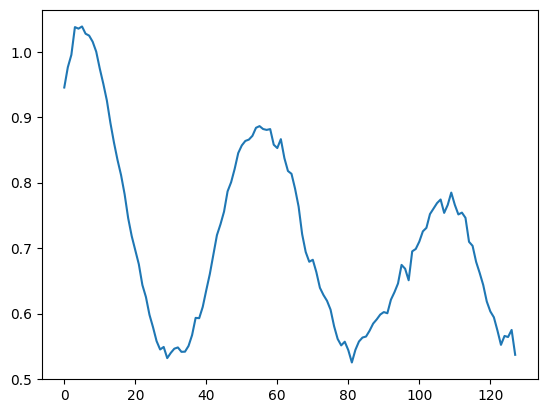

In [7]:
import matplotlib.pyplot as plt

plt.plot(point_forecast[1])

In [8]:
point_forecast
#把point_forecast 转置
#point_forecast = point_forecast.transpose(1,0)

array([[ 9.83747244e-01,  1.01065361e+00,  1.00325358e+00,
         9.46732640e-01,  8.51727128e-01,  7.23342836e-01,
         5.61207771e-01,  3.80571663e-01,  1.79073259e-01,
        -2.67257988e-02, -2.32114047e-01, -4.27830368e-01,
        -5.99026322e-01, -7.64772177e-01, -8.78619432e-01,
        -9.67811108e-01, -1.01031446e+00, -1.01604700e+00,
        -9.84019876e-01, -9.12956357e-01, -8.01771522e-01,
        -6.50981665e-01, -4.71728057e-01, -2.84182280e-01,
        -7.70836174e-02,  1.27240524e-01,  3.29177767e-01,
         5.12138844e-01,  6.82633519e-01,  8.17140102e-01,
         9.16526914e-01,  9.84637737e-01,  1.01296473e+00,
         1.00419533e+00,  9.52391267e-01,  8.54743481e-01,
         7.38911271e-01,  5.88088036e-01,  4.05613095e-01,
         2.08451092e-01, -5.27352095e-04, -2.10887402e-01,
        -4.13263947e-01, -6.05157018e-01, -7.68680930e-01,
        -8.80226731e-01, -9.74400759e-01, -1.02037847e+00,
        -1.02086878e+00, -9.88066435e-01, -9.13966298e-0

In [9]:
import torch
# 生成一个随机的三维张量
tensor = torch.randn(3, 4, 5)
print(tensor)

tensor([[[-1.4803e+00, -1.5812e-02,  1.2422e+00,  7.1068e-01,  5.3010e-01],
         [ 9.3693e-01, -9.9858e-02, -7.0595e-01,  4.4047e-01,  9.0993e-01],
         [ 2.7587e-01, -2.6830e-01, -7.6077e-01, -3.3429e-01, -5.3475e-02],
         [ 4.8619e-01, -1.2006e-01,  8.7189e-01,  1.2230e+00,  2.4765e-01]],

        [[-2.6561e-01,  4.4875e-01,  7.7485e-01,  9.6150e-01, -3.8399e-01],
         [ 3.5695e-01, -1.0966e-01,  2.1244e-01,  1.7934e+00, -1.6896e-01],
         [ 1.2638e+00,  9.2017e-01,  1.9483e-01,  9.7142e-04, -5.0868e-01],
         [ 7.6773e-01, -8.4454e-01, -1.0094e+00, -7.9931e-01,  6.3698e-01]],

        [[-1.4081e-01,  7.8177e-01, -1.5194e-01, -7.6514e-01, -4.1584e-02],
         [-3.3898e-01,  7.9114e-01, -1.4979e+00,  1.0844e+00,  2.8159e-01],
         [-1.1613e-01, -1.2569e+00,  7.2516e-01, -1.7582e+00, -1.4058e+00],
         [ 1.8520e+00, -8.2236e-01,  1.0202e+00,  4.1478e-02, -3.0725e+00]]])


In [10]:
tensor[:,:,0:2]

tensor([[[-1.4803, -0.0158],
         [ 0.9369, -0.0999],
         [ 0.2759, -0.2683],
         [ 0.4862, -0.1201]],

        [[-0.2656,  0.4487],
         [ 0.3570, -0.1097],
         [ 1.2638,  0.9202],
         [ 0.7677, -0.8445]],

        [[-0.1408,  0.7818],
         [-0.3390,  0.7911],
         [-0.1161, -1.2569],
         [ 1.8520, -0.8224]]])